# Проект для «Викишоп»

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
toxic_df = pd.read_csv('/datasets/toxic_comments.csv')
toxic_df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
toxic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Проверим сбалансированность классов

In [4]:
display(toxic_df['toxic'].value_counts())
ratio = toxic_df['toxic'].value_counts()[0] / toxic_df['toxic'].value_counts()[1]
ratio

0    143346
1     16225
Name: toxic, dtype: int64

8.834884437596301

Классы не сбалансированы с коэффициентом 1:8.83. Найдем оптимальный способ балансировки и потом сравним качество.

Этапы:

Изменение весов в модели обучения

Ресемплирование с уменьшением класса 0

Подготовим признаки и целевой признак перед обучением.

In [5]:
%%time

m = Mystem()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

toxic_df['lemm_text'] = toxic_df['text'].apply(lemmatize_text)

toxic_df = toxic_df.drop(['text'], axis = 1)
del m

CPU times: user 40.6 s, sys: 6.85 s, total: 47.4 s
Wall time: 1min 40s


Разобьем выборку в следующем соотношении 60/20/20. По причине большого размера выборки уменьшим количество кроссвалидаций до 3.

In [6]:
target = toxic_df['toxic']
features = toxic_df.drop(['toxic'], axis = 1)

In [7]:
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size = 0.4, 
                                                                              random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size = 0.5,
                                                                            random_state = 12345)

In [8]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
cv_counts = 3
count_tf_idf = TfidfVectorizer(stop_words = stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95742, 126482)
(31914, 126482)
(31915, 126482)


In [9]:
%%time

model = LogisticRegression()
train_f1 = cross_val_score(model, 
                      features_train, 
                      target_train, 
                      cv = cv_counts, 
                      scoring = 'f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6735400940998678
CPU times: user 11.9 s, sys: 12.1 s, total: 24.1 s
Wall time: 24.1 s


### Поменяем баланс классов

#### Веса классов

In [10]:
%%time

dict_class={0:1, 1:ratio}
model = LogisticRegression(class_weight=dict_class)
train_f1_balanced = cross_val_score(model, 
                                    features_train, 
                                    target_train, 
                                    cv = cv_counts, 
                                    scoring = 'f1').mean()
print('F1 на CV с балансированными классами', train_f1_balanced)

F1 на CV с балансированными классами 0.7512582899041655
CPU times: user 20.6 s, sys: 20.6 s, total: 41.3 s
Wall time: 41.3 s


In [11]:
%%time

model = LogisticRegression(class_weight='balanced')
train_f1_blnc = cross_val_score(model, 
                                    features_train, 
                                    target_train, 
                                    cv = cv_counts, 
                                    scoring = 'f1').mean()
print('F1 на CV с балансированными классами', train_f1_blnc)

F1 на CV с балансированными классами 0.7444308965221991
CPU times: user 16.1 s, sys: 16.7 s, total: 32.8 s
Wall time: 32.8 s


На обучающей выборке F1-метрика увеличилась. Встроенный метод повторяет значение F1.

#### Ресемплирование с уменьшением класса

Приравняем количество записей с классом 0 с количеством записей с классом 1.

In [12]:
toxic_train = toxic_df.iloc[target_train.index]

target_train_class_zero = toxic_train[toxic_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_train[toxic_train['toxic'] == 1]['toxic']

In [13]:
class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state = 12345)
_downsample = pd.concat([class_zero_downsample, target_train_class_one])

features_train_downsample = toxic_df.iloc[_downsample.index]
features_train_downsample, _downsample = shuffle(features_train_downsample,
                                                             _downsample,
                                                             random_state = 12345)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))
del count_tf_idf
del stopwords

In [14]:
model = LogisticRegression()
train_f1_downsampled = cross_val_score(model,
                      features_train_downsample, 
                      _downsample, 
                      cv = cv_counts, 
                      scoring = 'f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)

F1 на CV с уменьшением классов 0.8792825300830076


Наблюдаем значительный рост F1-метрики. Построим ROC-AUC графики и просмотрим таблицу результатов балансирования.

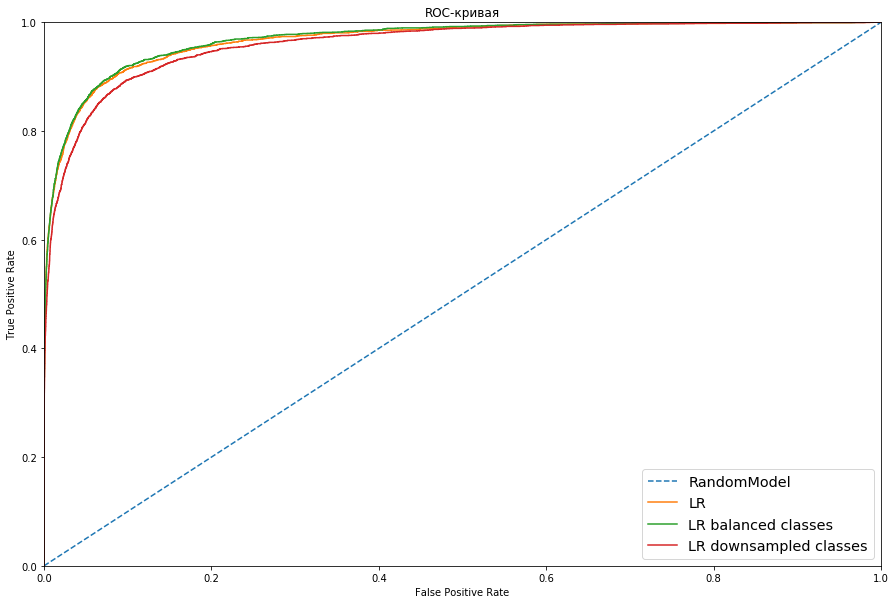

In [16]:
plt.figure(figsize = [15,10])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'RandomModel')
model = LogisticRegression()
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, model.predict(features_valid))
plt.plot(fpr, tpr, label = 'LR')
model = LogisticRegression(class_weight=dict_class)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, model.predict(features_valid))
plt.plot(fpr, tpr, label='LR balanсed classes')
model = LogisticRegression()
model.fit(features_train_downsample, _downsample)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, model.predict(features_valid))

plt.plot(fpr, tpr, label = 'LR downsampled classes')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = 'lower right', fontsize = 'x-large')
plt.title("ROC-кривая")
plt.show()

In [17]:
index = ['LogisticRegression',
         'LR balanсed classes',
         'LR downsampled classes']
data = {'F1 на CV':[train_f1,
                    train_f1_blnc,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data = data, index = index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.673540,0.727239,0.967525
LR balanсed classes,0.744431,0.762996,0.969334
LR downsampled classes,0.879283,0.695479,0.960052


Выберем метод балансировки по весу

### Вывод по шагу 1

Данные загружены. В рамках предобработки данных были получены признаки для дальнейшего обучения и общая выборка разделена на обучающую, валидационную и тестовую.

Выберем для дальнейшего использования классификатор, где учтен вес классов,исходя из тестирования показателей F1 и AUC-ROC. В обучении будем использовать именно этот метод балансирования.

## Обучение

Для обучения выберем следующие модели:

LogisticRegression

DecisionTreeClassifier

CatBoostClassifier

SGDClassifier

### Модель LogisticRegression

In [18]:
%%time

model = LogisticRegression()
prmtrs = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_class]}]


print('# Tuning hyperparameters for f1_score')
print()
clf = GridSearchCV(model, prmtrs, scoring = 'f1',cv = cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyperparameters for f1_score

Best parameters set:

{'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}

Grid scores on set:

0.714455 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.714545 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.714455 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.751426 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.751544 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.751258 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.764921 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.762277 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.764859 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}

CPU times: user 4min 

In [19]:
%%time

model = LogisticRegression()
model.set_params(**LR_best_params)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.764921323455282
F1 на валидации 0.7676588183029764
CPU times: user 19.8 s, sys: 20.6 s, total: 40.4 s
Wall time: 40.5 s


### Модель DecisionTreeClassifier

In [20]:
%%time

model = DecisionTreeClassifier()
prmtrs = [{'max_depth':[x for x in range(30,50,2)],
                'random_state':[12345],
                'class_weight':[dict_class]}]


print('# Tuning hyperparameters for f1_score')
print()
clf = GridSearchCV(model, prmtrs, scoring = 'f1',cv = cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyperparameters for f1_score

Best parameters set:

{'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 48, 'random_state': 12345}

Grid scores on set:

0.616925 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 30, 'random_state': 12345}
0.610969 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 32, 'random_state': 12345}
0.618525 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 34, 'random_state': 12345}
0.621639 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 36, 'random_state': 12345}
0.618858 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 38, 'random_state': 12345}
0.607957 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 40, 'random_state': 12345}
0.609750 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 42, 'random_state': 12345}
0.614160 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 44, 'random_state': 12345}
0.617789 for {'class_weight': 

In [21]:
%%time

model = DecisionTreeClassifier()
model.set_params(**DTC_best_params)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6222294422525377
F1 на валидации 0.6054352565034151
CPU times: user 27.4 s, sys: 0 ns, total: 27.4 s
Wall time: 27.5 s


### Модель CatBoostClassifier

In [22]:
%%time

model = CatBoostClassifier(verbose = False, iterations = 100)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
cv_f1_CBC = cross_val_score(model,
                            features_train, 
                            target_train, 
                            cv = cv_counts, 
                            scoring = 'f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.7189826116815015
F1 на валидации 0.7447037701974866
CPU times: user 18min 32s, sys: 3min 5s, total: 21min 37s
Wall time: 21min 42s


### Модель SGDClassifier

In [23]:
%%time

model = SGDClassifier()
prmtrs = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12345],
                'class_weight':[dict_class]}]


print('# Tuning hyperparameters for f1_score')
print()
clf = GridSearchCV(model, prmtrs, scoring = 'f1',cv = cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print("Grid scores on set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

# Tuning hyperparameters for f1_score

Best parameters set:

{'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.5, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12345}

Grid scores on set:

0.738449 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 12345}
0.717600 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 12345}
0.752431 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 12345}
0.737587 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 12345}
0.720393 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 12345}
0.748816 for {'class_weight': {0: 1, 1: 8.834884437596301}, '

In [24]:
%%time

model = SGDClassifier()
model.set_params(**SGDC_best_params)
model.fit(features_train, target_train)
target_predict = model.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_SGDC)
print('F1 на валидации', valid_f1_SGDC)

F1 на cv 0.7587496819928928
F1 на валидации 0.7636516381965837
CPU times: user 1.52 s, sys: 82.5 ms, total: 1.61 s
Wall time: 1.62 s


In [25]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC,
                    cv_f1_SGDC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC,
                           valid_f1_SGDC]}

scores_data = pd.DataFrame(data = data, index = index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.764921,0.767659,True
DecisionTreeClassifier,0.622229,0.605435,False
CatBoostClassifier,0.718983,0.744704,False
SGDClassifier,0.758750,0.763652,True


### Вывод по шагу 2

По критерию выполнения задачи к тестовому набору данных перейдут LogisticRegression и SGDClassifier.

## Выводы

Проведем получение F1-метрики, метрик precision, accuracy, recall и roc_auc и построим графики.

Метрики LogisticRegression
ROC AUC: 0.9644859975874468
F1: 0.7646619907476495
Precision: 0.733887138355772
Recall: 0.7981308411214953
Accuracy: 0.9505874980416732

Метрики SGDClassifier
ROC AUC: 0.969185603254939
F1: 0.7575928008998876
Precision: 0.690415171706817
Recall: 0.8392523364485981
Accuracy: 0.9459815133949554



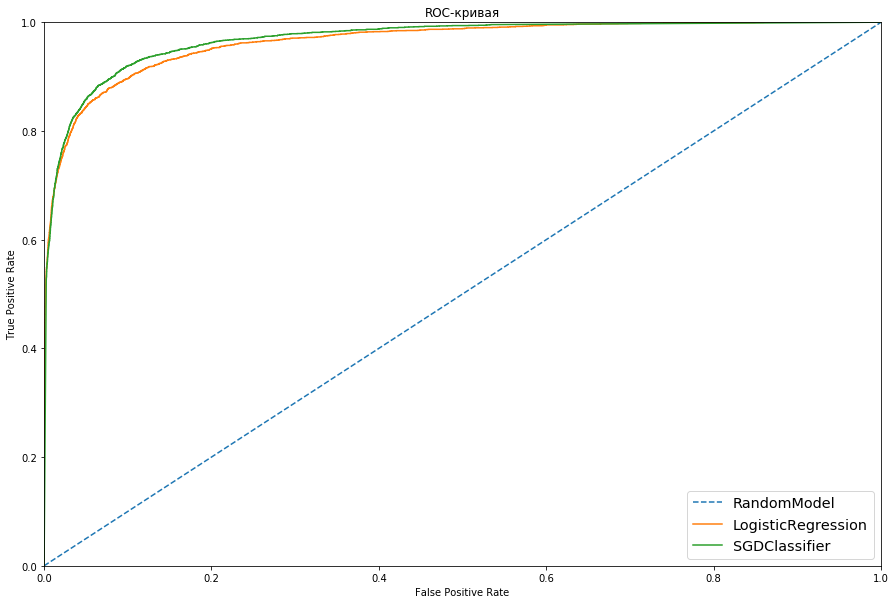

In [26]:
plt.figure(figsize = [15,10])

plt.plot([0, 1], [0, 1], linestyle = '--', label = 'RandomModel')


model = LogisticRegression()
model.set_params(**LR_best_params)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = model.predict(features_test)
plt.plot(fpr, tpr, label = 'LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

model = SGDClassifier()
model.set_params(**SGDC_best_params)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = model.predict(features_test)
plt.plot(fpr, tpr, label = 'SGDClassifier')
print('Метрики SGDClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc = 'lower right', fontsize = 'x-large')

plt.title("ROC-кривая")
plt.show()

## Итоговый вывод

В ходе работы над проектом было сделано:

Данные загружены и подготовленны для дальнейшего обучения на моделях.
Из рассмотренных способов был выбран способ баланса классов и далее данные разделены на обучающую, валидационную и тестовою выборку.
Модели обучены используя следующие классификаторы - LogisticRegression, CatBoostClassifier, SGDClassifier и DecisionTreeClassifier; выбраны лучшие из них на валидационной выборке.
Показаны параметры качества моделей.
В исходных данных большое количество признаков. Так как TF-IDF конвертирует текст в численные значения, лучшими моделями стали LogisticRegression и SGDClassifier. CatBoostClassifier как обычно расходует много времени на вычисления - в ходе тестов этот классификатор мог обучатся до 3 часов.

На тестовой выбоке по метрике F1 лучше всего себя показал LogisticRegression , немногим больше чем у SGDClassifier. Данная модель обладает лучшими показателями Precision и Accuracy, что говорит о том, что токсичные комментарии находятся лучше.

В тоже время классификатор SGDClassifier показал себя лучше в ROC AUC и Recall метриках - модель способна обработать больше записей.